In [1]:
# import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_validate 
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

### 1. Cleaned Data

#### 1.1. Load data and display setting

In [2]:
diabetic = pd.read_csv('data.csv')

In [3]:
diabetic.shape

(101766, 50)

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
diabetic_df = diabetic.replace('?', np.nan)

In [6]:
# keep only first encounter for every unique patient
diabetic_df = diabetic_df.sort_values('encounter_id')
diabetic_df.drop_duplicates(subset = ['patient_nbr'], keep = 'first', inplace = True)

In [7]:
diabetic_df.shape

(71518, 50)

#### 1.2 Remove rows and coluns

In [8]:
# remove expired or hospice-bound patients
diabetic_df = diabetic_df[~diabetic_df['discharge_disposition_id'].isin([11,13,14,19,20,21])]

In [9]:
# remove unknown-gender patients
diabetic_df.drop(diabetic_df.loc[diabetic_df.gender=='Unknown/Invalid'].index,inplace=True)

In [10]:
# remove encounter ID, patient NBR, weight, medical specialty, and payer code
diabetic_df.drop(['encounter_id','patient_nbr','weight','medical_specialty','payer_code'],\
                 axis = 1, inplace = True)

In [13]:
# discretize ID columns
diabetic_df['admission_type_id'] = diabetic_df['admission_type_id'].astype('str')
diabetic_df['admission_source_id'] = diabetic_df['admission_source_id'].astype('str')
diabetic_df['discharge_disposition_id'] = diabetic_df['discharge_disposition_id'].astype('str')

In [14]:
diabetic_df.shape

(69970, 45)

### 2. Feature Engineering

#### 2.1 Categorical to Numeric

In [15]:
# binarize target variable: readmitted < 30 days or other
diabetic_df['readmit_30d'] = (diabetic_df['readmitted'] == '<30')

In [16]:
# convert age to a continuous variable
diabetic_df['age_num'] = diabetic_df['age'].replace(
    ['[0-10)','[10-20)','[20-30)','[30-40)','[40-50)','[50-60)','[60-70)','[70-80)','[80-90)','[90-100)'],
    [0,10,20,30,40,50,60,70,80,90])

#### 2.2 Diagnose Features

In [17]:
# keep main disease class only
diabetic_df['diag_1'] = diabetic_df['diag_1'].str.split('.', expand = True).drop(1, axis = 1)
diabetic_df['diag_2'] = diabetic_df['diag_2'].str.split('.', expand = True).drop(1, axis = 1)
diabetic_df['diag_3'] = diabetic_df['diag_3'].str.split('.', expand = True).drop(1, axis = 1)

In [18]:
# create a binary variable for each diagnosis in diag_1,2, or 3 that has sample size >500
count_1 = diabetic_df['diag_1'].value_counts()
index_1 = count_1[count_1>=500].index.tolist()

count_2 = diabetic_df['diag_2'].value_counts()
index_2 = count_2[count_2>=500].index.tolist()

count_3 = diabetic_df['diag_3'].value_counts()
index_3 = count_3[count_3>=500].index.tolist()

diagnoses = set(index_1 + index_2 + index_3)

for d in diagnoses:
    diabetic_df[d+'_diag'] = ((diabetic_df['diag_1']==d)|
                              (diabetic_df['diag_2']==d)|
                              (diabetic_df['diag_3']==d))

#### 2.3  Medication Features

In [19]:
# binarize medication features with minority classes > 500 samples: used/not used
for col in ['metformin','repaglinide','glimepiride','glipizide', 'glyburide','pioglitazone',
            'rosiglitazone','insulin']:
    diabetic_df[col+'_used'] = np.where(diabetic_df[col]=='No', False, True)

In [20]:
### 2.4 removing columns <500

#### 2.4 finalizing dataset and dummifying categorical variables

In [21]:
# remove features used to engineer new features
diabetic_final = diabetic_df.drop(['age',
                                   'diag_1','diag_2','diag_3',
                                   'metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
                                   'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
                                   'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide',
                                   'citoglipton','insulin','glyburide-metformin','glipizide-metformin',
                                   'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone',
                                   'readmitted'],
                                 axis = 1)

#### 2.5 Export dataset

In [22]:
# dummify features
diabetic_final = pd.get_dummies(diabetic_final, drop_first = True)
diabetic_final.shape

(69970, 119)

In [25]:
diabetic_final.to_csv('diabetic_model_set.csv',  index = False)

 _____________________________________________________________________________________


In [26]:
data = pd.read_csv('diabetic_model_set.csv')

In [27]:
data.drop(['admission_type_id_4',
 'admission_type_id_7',
 'admission_type_id_8',
 'discharge_disposition_id_10',
 'discharge_disposition_id_12',
 'discharge_disposition_id_15',
 'discharge_disposition_id_16',
 'discharge_disposition_id_17',
 'discharge_disposition_id_23',
 'discharge_disposition_id_24',
 'discharge_disposition_id_27',
 'discharge_disposition_id_28',
 'discharge_disposition_id_7',
 'discharge_disposition_id_8',
 'discharge_disposition_id_9',
 'admission_source_id_10',
 'admission_source_id_11',
 'admission_source_id_13',
 'admission_source_id_14',
 'admission_source_id_20',
 'admission_source_id_22',
 'admission_source_id_25',
 'admission_source_id_3',
 'admission_source_id_8',
 'admission_source_id_9'], axis = 1, inplace = True)

In [28]:
diag_variables = ['996_diag', '820_diag',
       '585_diag', '599_diag', '682_diag', '413_diag', '433_diag', '574_diag',
       '296_diag', '411_diag', '584_diag', '486_diag', '496_diag', '440_diag',
       '562_diag', '305_diag', '285_diag', 'V45_diag', '577_diag', '410_diag',
       '414_diag', '560_diag', '780_diag', '278_diag', '722_diag', '38_diag',
       '403_diag', '250_diag', '786_diag', '401_diag', '424_diag', 'V57_diag',
       '276_diag', '435_diag', '427_diag', '715_diag', '518_diag', '272_diag',
       '434_diag', '425_diag', '428_diag', '491_diag', '707_diag', '41_diag',
       '493_diag']

In [29]:
diag_dict = {False : 0, True:1}
for diag_col in diag_variables:
    data[diag_col].replace(diag_dict, inplace = True)

In [30]:
med_variables = ['metformin_used', 'repaglinide_used', 'glimepiride_used',
       'glipizide_used', 'glyburide_used', 'pioglitazone_used',
       'rosiglitazone_used', 'insulin_used']
med_dict = {False : 0, True:1}
for med_col in med_variables:
    data[med_col].replace(med_dict, inplace = True)

In [31]:
readmitted_dict = {True : 1, False: 0}
data.readmit_30d.replace(readmitted_dict, inplace = True)

In [32]:
top_43_features = ['number_inpatient', 'discharge_disposition_id_22', 'time_in_hospital',
       'discharge_disposition_id_3', 'age_num', 'num_medications',
       'number_diagnoses', 'discharge_disposition_id_5', 'num_lab_procedures',
       '434_diag', '786_diag', '403_diag', 'diabetesMed_Yes',
       'number_emergency', '401_diag', 'discharge_disposition_id_2',
       '428_diag', 'insulin_used', 'num_procedures', '440_diag', '707_diag',
       '272_diag', 'number_outpatient', '820_diag', 'admission_type_id_3',
       '278_diag', 'discharge_disposition_id_6', 'change_No', '414_diag',
       'admission_source_id_7', 'race_Other', 'admission_type_id_6',
       '250_diag', '305_diag', 'metformin_used', 'gender_Male', '722_diag',
       'race_Caucasian', 'glipizide_used', 'admission_type_id_5',
       'A1Cresult_None', '574_diag', 'pioglitazone_used']

## 3. Modeling

### 3.1 Train, Test set split

In [33]:
X = data.drop (['readmit_30d'], axis=1)
y = data['readmit_30d']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [35]:
y_train.value_counts() / len(y_train) * 100

0    91.028298
1     8.971702
Name: readmit_30d, dtype: float64

In [ ]:
# ## standard scaler:: 
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

### 3.2 Logistic regression modeling

### 3.2.1 Logistic Regression Model Fitting

In [36]:
feature_names = X_train.columns

In [37]:
logistic = LogisticRegression(solver='liblinear',
                              penalty='l2',
                              C=0.01,
                              random_state=42,
                             class_weight = 'balanced')

logistic.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced', random_state=42,
                   solver='liblinear')

In [38]:
from sklearn.linear_model import LogisticRegression
y_pred = logistic.predict(X_test)

### 3.2.4 Grid Search

In [39]:
from sklearn.model_selection import cross_validate 
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import GridSearchCV 
pipe_logistic = make_pipeline(LogisticRegression(random_state=42))
param_range = [0.01, 0.1, 1.0, 10, 100, 200] 

param_grid = [{'logisticregression__C': param_range}] 

gs = GridSearchCV(estimator=pipe_logistic,
                  param_grid=param_grid, 
                  scoring='roc_auc', 
                  cv=5,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.6270854760721004
{'logisticregression__C': 0.1}


In [44]:
from sklearn.metrics import roc_auc_score

In [45]:
roc_auc_score(y_test, y_pred)

0.6034815444243905

In [47]:
print(gs.score(X_train, y_train)) 
print(gs.score(X_test, y_test)) 

0.6331904760162949
0.6138082101298863


### 3.2.2 Confusion Matrix

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],8534,4205
True[1],581,674


In [49]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_pred))
print('accuracy_score: %.3f' % accuracy_score(y_test, y_pred))
print('precision_score: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('recall_score: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('f1_score: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

accuracy_score: 0.658
precision_score: 0.138
recall_score: 0.537
f1_score: 0.220


### 3.2.3 precision - recall curve

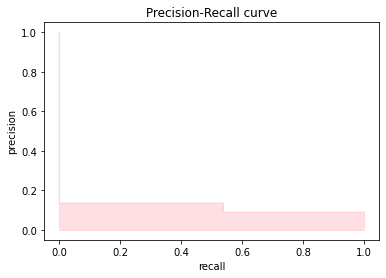

In [50]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.figure()
plt.step(recall, precision, color = "pink", alpha = 0.3, where = 'post')
plt.fill_between(recall, precision, step = 'post', alpha=0.5, color = "pink")
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall curve');

### 3.2.5  Logistic Regression — Feature Selection(RFECV)

In [51]:
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=logistic, step=1, cv= 5, scoring='roc_auc')
rfecv.fit(X_train, y_train)

RFECV(cv=5,
      estimator=LogisticRegression(C=0.01, class_weight='balanced',
                                   random_state=42, solver='liblinear'),
      scoring='roc_auc')

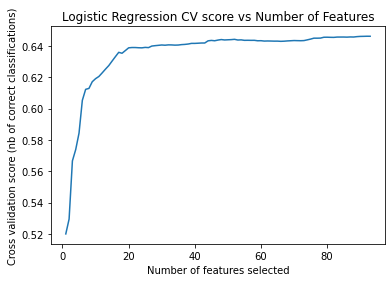

In [52]:
# check  number of features which gives the maximum accuracy
plt.figure()
plt.title('Logistic Regression CV score vs Number of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [53]:
coef = logistic.coef_[0]
for n,v in zip(feature_names, coef):
    print('Feature : %s, Score %.3f' % (n,v))

Feature : time_in_hospital, Score 0.022
Feature : num_lab_procedures, Score 0.002
Feature : num_procedures, Score 0.002
Feature : num_medications, Score -0.000
Feature : number_outpatient, Score 0.001
Feature : number_emergency, Score 0.142
Feature : number_inpatient, Score 0.332
Feature : number_diagnoses, Score 0.028
Feature : age_num, Score 0.004
Feature : 305_diag, Score -0.117
Feature : 722_diag, Score -0.290
Feature : 413_diag, Score -0.123
Feature : 296_diag, Score 0.074
Feature : 486_diag, Score -0.177
Feature : 493_diag, Score -0.119
Feature : 440_diag, Score 0.281
Feature : 278_diag, Score -0.192
Feature : 411_diag, Score 0.027
Feature : 574_diag, Score -0.152
Feature : 491_diag, Score -0.040
Feature : 425_diag, Score 0.020
Feature : 577_diag, Score 0.120
Feature : 250_diag, Score 0.035
Feature : 41_diag, Score -0.135
Feature : 427_diag, Score -0.058
Feature : 560_diag, Score 0.005
Feature : 276_diag, Score -0.036
Feature : 272_diag, Score -0.210
Feature : 496_diag, Score 0.0

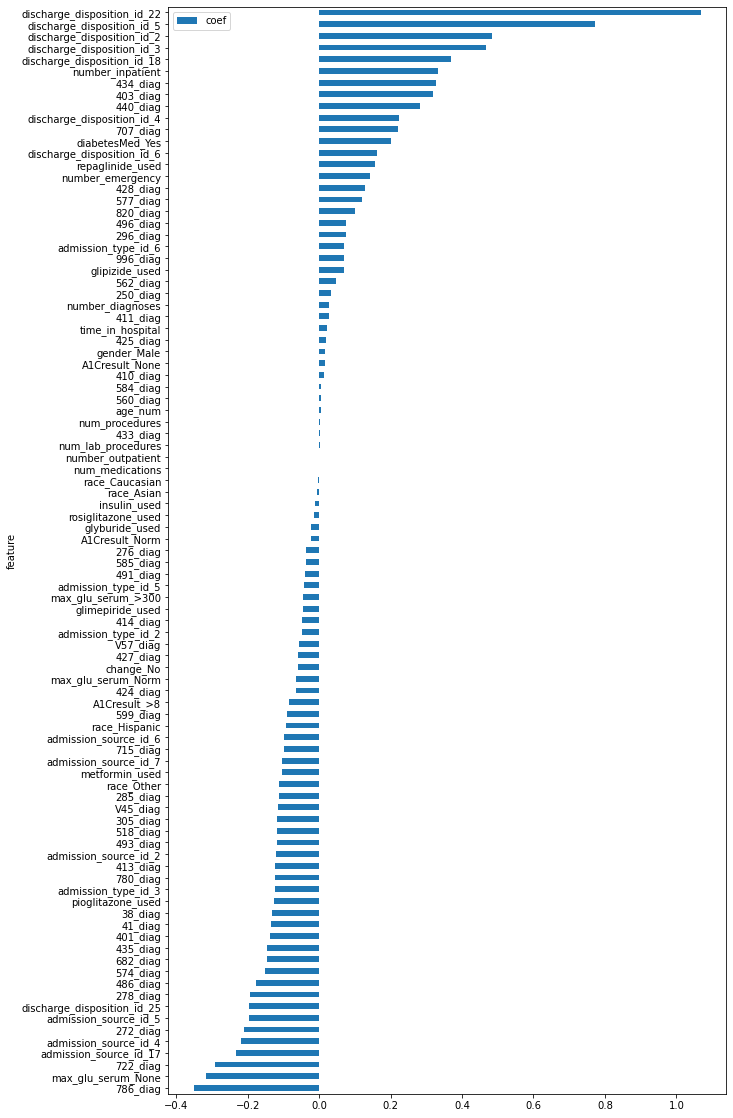

In [54]:
feature_coef = pd.DataFrame({'feature':feature_names,'coef':coef}).sort_values(by='coef')
feature_coef.plot.barh(x= 'feature', y='coef',figsize = (10,20))

### 3.3 Decision Tree modeling

### 3.3.1 Decision Tree model Fitting

In [55]:
X = data.drop (['readmit_30d'], axis=1)
y = data['readmit_30d']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [56]:
tree = DecisionTreeClassifier(criterion='gini',
                              max_depth= 5, 
                              random_state=42, 
                              class_weight='balanced')
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [57]:
y_pred = tree.predict(X_test)

#### 3.3.1.2  Grid Search

In [67]:
from numpy import mean
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
    
params = {'max_depth': [3, 5, 7,9],
          'min_samples_split' : [3, 5, 10, 15],
          'min_samples_leaf' : [1, 2, 5, 10]}

grid = GridSearchCV(estimator=tree, 
                    param_grid=params, 
                    n_jobs=1, 
                    cv= 5, 
                    scoring='roc_auc')
grid_result = grid.fit(X_train, y_train)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.622579 using {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 3}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 15}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 3}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 15}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 3}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 5}
0.592972 (0

In [69]:
print(grid_result.score(X_train, y_train)) 
print(grid_result.score(X_test, y_test)) 

0.6467207766613493
0.6231590788897163


In [70]:
y_train_pred = grid_result.predict(X_train)

In [71]:
y_test_pred = grid_result.predict(X_test)

In [72]:
grid_result.score(X_train, y_train)

0.6467207766613493

In [73]:
grid_result.score(X_test, y_test)

0.6231590788897163

In [74]:
print(roc_auc_score(y_train, y_train_pred))
print(roc_auc_score(y_test, y_test_pred))

0.604958088637338
0.592885604923113


#### 3.3.1.3  Confusion Matrix

In [75]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],9340,3399
True[1],687,568


In [76]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
print('precision_score: %.3f' % precision_score(y_true=y_test, y_pred=y_test_pred))
print('recall_score: %.3f' % recall_score(y_true=y_test, y_pred=y_test_pred))
print('f1_score: %.3f' % f1_score(y_true=y_test, y_pred=y_test_pred))
print('roc_auc_score:',roc_auc_score(y_test, y_test_pred))

precision_score: 0.143
recall_score: 0.453
f1_score: 0.218
roc_auc_score: 0.592885604923113


### 3.3.1.4 precision recall curve

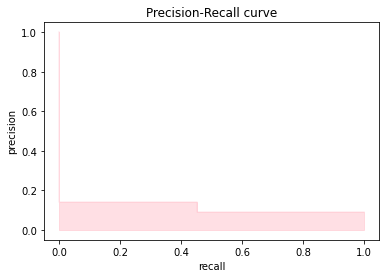

In [77]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
plt.figure()
plt.step(recall, precision, color = "pink", alpha = 0.3, where = 'post')
plt.fill_between(recall, precision, step = 'post', alpha=0.5, color = "pink")
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall curve');

### 3.3.1.5 featrre importance

In [78]:
grid.best_estimator_.feature_importances_

array([2.46846411e-01, 1.69268591e-01, 8.10061222e-02, 2.93033998e-02,
       2.62129726e-02, 5.11443736e-02, 1.43537549e-01, 2.72167792e-02,
       6.96568695e-02, 2.21945844e-02, 1.94564849e-03, 1.65091166e-03,
       8.77859597e-04, 0.00000000e+00, 2.57939678e-03, 3.22364906e-02,
       9.78640099e-03, 3.00648256e-02, 9.22588559e-04, 0.00000000e+00,
       3.03383333e-03, 6.67994456e-03, 1.12442096e-02, 0.00000000e+00,
       7.44160024e-05, 4.59305504e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.61546961e-03, 1.93006378e-03, 1.12911175e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.25835735e-03,
       5.82775824e-03, 0.00000000e+00, 0.00000000e+00])

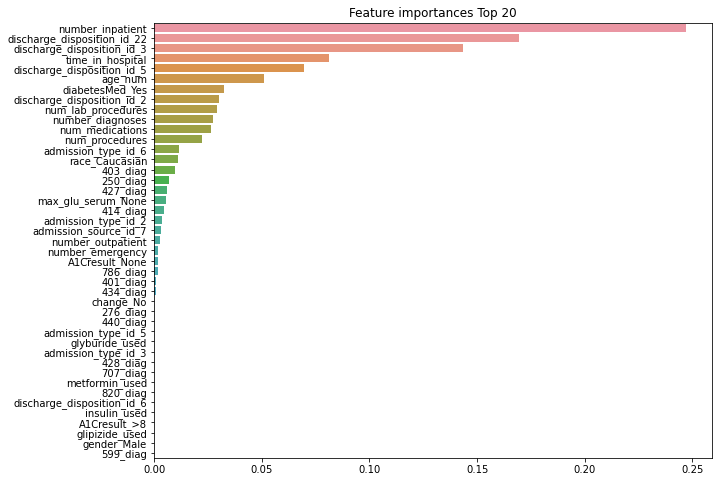

In [79]:
ftr_importances_values = grid.best_estimator_.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_sort = ftr_importances.sort_values(ascending=False)
plt.figure(figsize=(10,8))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_sort , y = ftr_sort.index)
plt.show()

In [82]:
feature_importances = pd.DataFrame(grid.best_estimator_.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [81]:
feature_importances

,importance
number_inpatient,0.246846
discharge_disposition_id_22,0.169269
discharge_disposition_id_3,0.143538
time_in_hospital,0.081006
discharge_disposition_id_5,0.069657
age_num,0.051144
diabetesMed_Yes,0.032236
discharge_disposition_id_2,0.030065
num_lab_procedures,0.029303
number_diagnoses,0.027217


### 3.3.2 Tree model : fit top 43 Feautres

### 3.3.2.1 top 43 features

In [61]:
top_43_features = ['number_inpatient', 'discharge_disposition_id_22', 'time_in_hospital',
       'num_lab_procedures', 'num_medications', 'age_num',
       'discharge_disposition_id_3', 'number_diagnoses',
       'discharge_disposition_id_5', 'num_procedures', 'number_emergency',
       '786_diag', '434_diag', '428_diag', 'number_outpatient',
       'diabetesMed_Yes', '403_diag', 'discharge_disposition_id_2', '401_diag',
       'insulin_used', 'admission_source_id_7', '250_diag', 'race_Caucasian',
       'gender_Male', 'change_No', '414_diag', 'admission_type_id_3',
       'glipizide_used', 'discharge_disposition_id_6', '820_diag',
       'metformin_used', '707_diag', 'admission_type_id_2', 'A1Cresult_None',
       'admission_type_id_6', '276_diag', '440_diag', 'admission_type_id_5',
       'glyburide_used', 'max_glu_serum_None', '427_diag', 'A1Cresult_>8',
       '599_diag']

### 3.3.2.2  train/test set split

In [62]:
X = data[top_43_features]
y= data['readmit_30d']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### 3.3.2.3 : decision tree

In [85]:
tree = DecisionTreeClassifier(criterion='gini',
                              max_depth= 5, 
                              random_state=42,
                              class_weight='balanced')
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [86]:
y_pred = tree.predict(X_test)

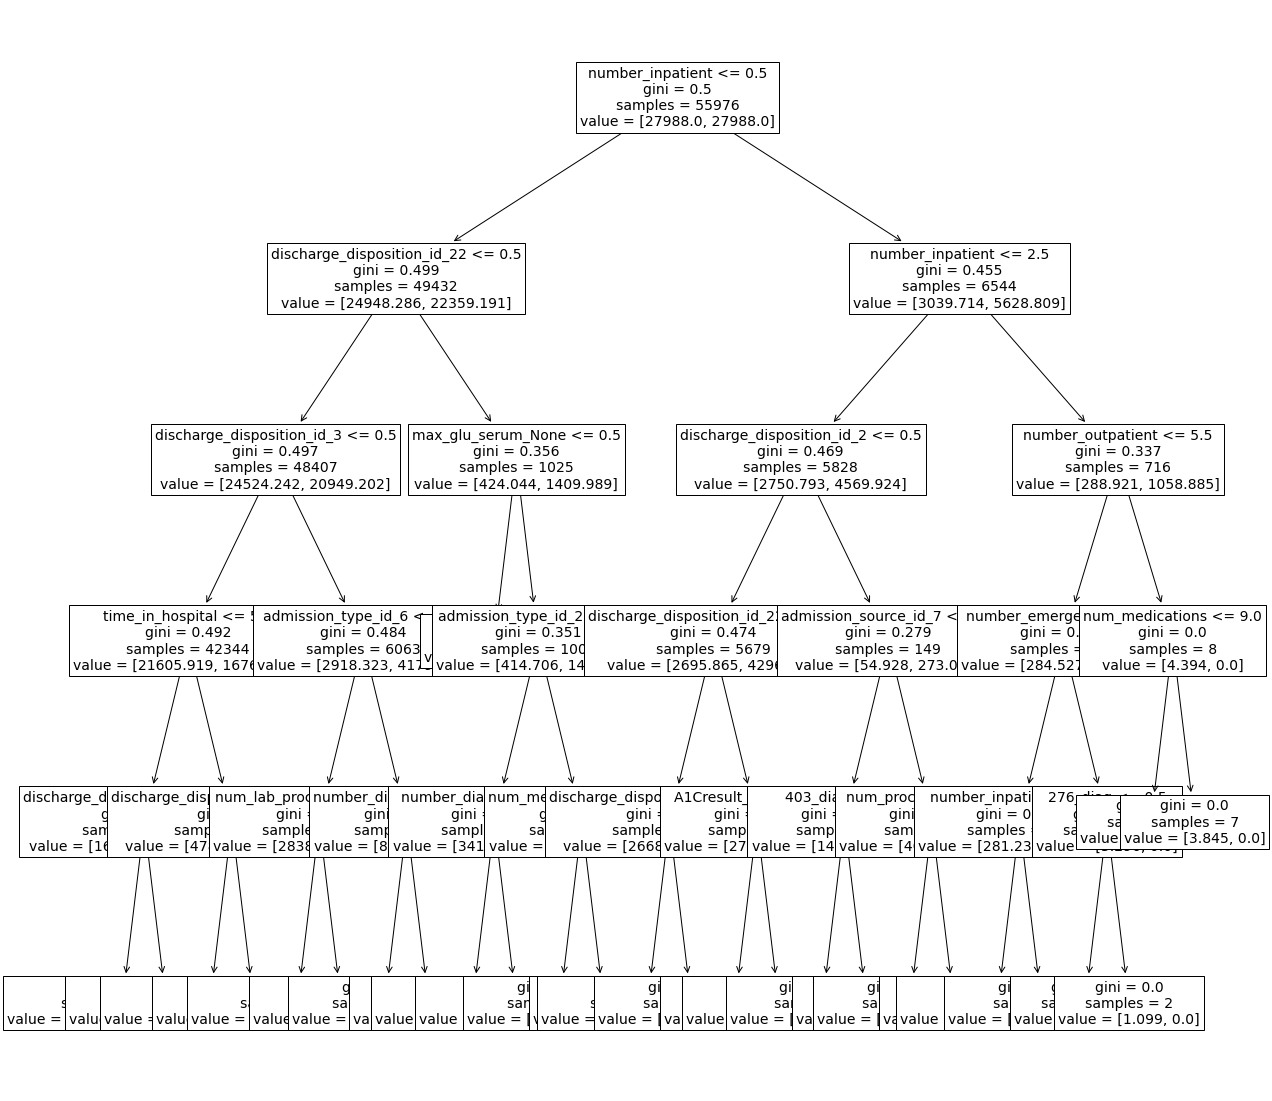

In [87]:
from sklearn.tree import plot_tree
# feature_names=X.column.tolist()
plt.figure(figsize=(20,20))
plot_tree(tree, feature_names=X_train.columns, fontsize=14)
plt.show()

### 3.3.2.4 Grid Search

In [88]:
# grid search class weights with decision tree for imbalance classification
from numpy import mean
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier


params = {'max_depth': [3, 5, 7,9,11],
          'min_samples_split' : [3, 5, 10, 15],
          'min_samples_leaf' : [1, 2, 3, 4, 5, 10]}

grid = GridSearchCV(estimator=tree, 
                    param_grid=params, 
                    n_jobs=-1, 
                    cv= 5, 
                    scoring='roc_auc')
grid_result = grid.fit(X_train, y_train)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.622579 using {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 3}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 15}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 3}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 15}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 3}
0.592972 (0.005163) with: {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 5}
0.592972 (0

In [89]:
print(grid_result.score(X_train, y_train)) 
print(grid_result.score(X_test, y_test)) 

0.6467207766613493
0.6231590788897163


In [90]:
y_train_pred = grid_result.predict(X_train)

In [91]:
y_test_pred = grid_result.predict(X_test)

In [92]:
grid_result.score(X_train, y_train)

0.6467207766613493

In [93]:
grid_result.score(X_test, y_test)

0.6231590788897163

In [94]:
print(roc_auc_score(y_train, y_train_pred))
print(roc_auc_score(y_test, y_test_pred))

0.604958088637338
0.592885604923113


### 3.3.2.5  Confusion Matrix

In [95]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],9340,3399
True[1],687,568


In [96]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
print('precision_score: %.3f' % precision_score(y_true=y_test, y_pred=y_test_pred))
print('recall_score: %.3f' % recall_score(y_true=y_test, y_pred=y_test_pred))
print('f1_score: %.3f' % f1_score(y_true=y_test, y_pred=y_test_pred))
print('ROCAUC score:',roc_auc_score(y_test, y_test_pred))

precision_score: 0.143
recall_score: 0.453
f1_score: 0.218
ROCAUC score: 0.592885604923113


### 3.3.2.6 precision recall curve

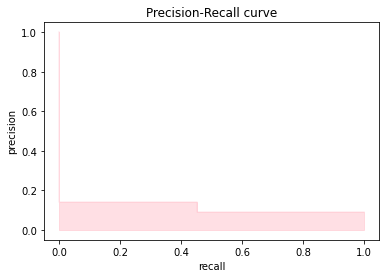

In [97]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
plt.figure()
plt.step(recall, precision, color = "pink", alpha = 0.3, where = 'post')
plt.fill_between(recall, precision, step = 'post', alpha=0.5, color = "pink")
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall curve');

### 3.3.2.7 fearuer importance

In [99]:
for name, value in zip(X_train.columns , grid.best_estimator_.feature_importances_): 
    print('{} : {:.5f}'.format(name, value))

number_inpatient : 0.24685
discharge_disposition_id_22 : 0.16927
time_in_hospital : 0.08101
num_lab_procedures : 0.02930
num_medications : 0.02621
age_num : 0.05114
discharge_disposition_id_3 : 0.14354
number_diagnoses : 0.02722
discharge_disposition_id_5 : 0.06966
num_procedures : 0.02219
number_emergency : 0.00195
786_diag : 0.00165
434_diag : 0.00088
428_diag : 0.00000
number_outpatient : 0.00258
diabetesMed_Yes : 0.03224
403_diag : 0.00979
discharge_disposition_id_2 : 0.03006
401_diag : 0.00092
insulin_used : 0.00000
admission_source_id_7 : 0.00303
250_diag : 0.00668
race_Caucasian : 0.01124
gender_Male : 0.00000
change_No : 0.00007
414_diag : 0.00459
admission_type_id_3 : 0.00000
glipizide_used : 0.00000
discharge_disposition_id_6 : 0.00000
820_diag : 0.00000
metformin_used : 0.00000
707_diag : 0.00000
admission_type_id_2 : 0.00362
A1Cresult_None : 0.00193
admission_type_id_6 : 0.01129
276_diag : 0.00000
440_diag : 0.00000
admission_type_id_5 : 0.00000
glyburide_used : 0.00000
max

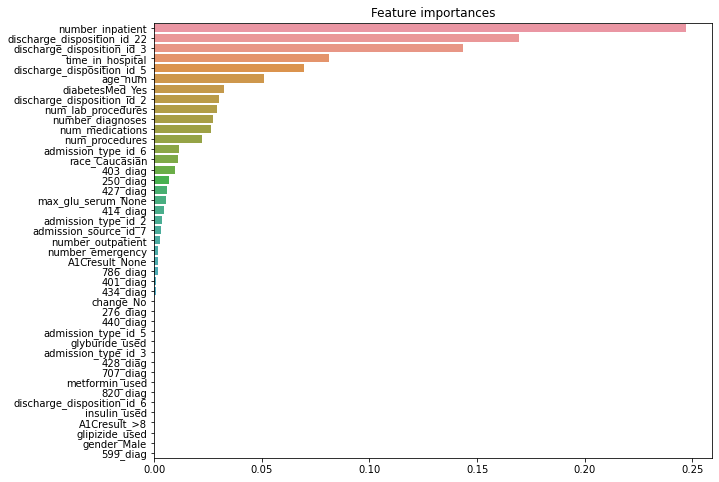

In [100]:
ftr_importances_values = grid.best_estimator_.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_sort = ftr_importances.sort_values(ascending=False)
plt.figure(figsize=(10,8))
plt.title('Feature importances')
sns.barplot(x=ftr_sort , y = ftr_sort.index)
plt.show()

In [101]:
feature_importances = pd.DataFrame(grid.best_estimator_.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False) 

In [102]:
feature_importances 

,importance
number_inpatient,0.246846
discharge_disposition_id_22,0.169269
discharge_disposition_id_3,0.143538
time_in_hospital,0.081006
discharge_disposition_id_5,0.069657
age_num,0.051144
diabetesMed_Yes,0.032236
discharge_disposition_id_2,0.030065
num_lab_procedures,0.029303
number_diagnoses,0.027217


### 3.3.3  Random Forest : model fit - class_weight = 'balanced'

In [103]:
X = data.drop (['readmit_30d'], axis=1)
y = data['readmit_30d']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [104]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=500, 
                                random_state=42,
                               class_weight = 'balanced',
                               max_depth = 5)

In [105]:
forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=500,
                       random_state=42)

In [106]:
y_pred = forest.predict(X_test)

### 3.3.3.1 Grid Search

In [107]:
params = {'n_estimators' : [150, 200],
        'max_depth' : [5, 8, 10, 12],
        'min_samples_split' : [5, 8, 10, 15],
        'min_samples_leaf' : [1, 2, 5]}
grid = GridSearchCV(estimator=forest, 
                    param_grid=params, 
                    n_jobs=1, 
                    cv= 5, 
                    scoring='roc_auc',
                    verbose = 1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 67.7min finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=5, n_estimators=500,
                                              random_state=42),
             n_jobs=1,
             param_grid={'max_depth': [5, 8, 10, 12],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [5, 8, 10, 15],
                         'n_estimators': [150, 200]},
             scoring='roc_auc', verbose=1)

In [108]:
grid.best_params_

{'max_depth': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 15,
 'n_estimators': 200}

In [109]:
y_train_pred = grid.predict(X_train)

In [110]:
y_test_pred = grid.predict(X_test)

In [111]:
roc_auc_score(y_test, y_pred)

0.6034325997681306

In [112]:
print(grid.score(X_train, y_train)) 
print(grid.score(X_test, y_test)) 

0.7307544707279806
0.6455215952267546


In [113]:
roc_auc_score(y_train, y_train_pred)

0.66310353610421

In [114]:
roc_auc_score(y_test, y_test_pred)

0.6037662365687575

### 3.3.3.2 confusion Matrix

In [115]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],9333,3406
True[1],659,596


In [116]:
print('accuracy_score: %.3f' % accuracy_score(y_test, y_test_pred))
print('precision_score: %.3f' % precision_score(y_true=y_test, y_pred=y_test_pred))
print('recall_score: %.3f' % recall_score(y_true=y_test, y_pred=y_test_pred))
print('f1_score: %.3f' % f1_score(y_true=y_test, y_pred=y_test_pred))

accuracy_score: 0.710
precision_score: 0.149
recall_score: 0.475
f1_score: 0.227


### 3.3.3.3 precision recall curve

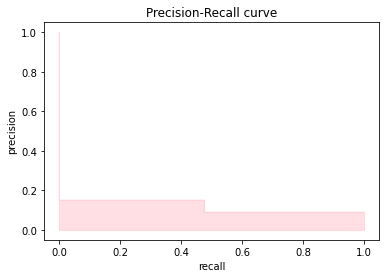

In [117]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)

plt.figure()
plt.step(recall, precision, color = "pink", alpha = 0.3, where = 'post')
plt.fill_between(recall, precision, step = 'post', alpha=0.5, color = "pink")
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall curve');

### 3.3.3.4 Fearure importance

In [118]:
grid.best_estimator_.feature_importances_

array([0.07044194, 0.05802344, 0.02260851, 0.06041854, 0.01291031,
       0.0194497 , 0.11520568, 0.04625622, 0.05272286, 0.00261306,
       0.00300221, 0.00278152, 0.00205071, 0.00333509, 0.00226486,
       0.0049099 , 0.00328013, 0.00260225, 0.00246194, 0.0029599 ,
       0.00207503, 0.00106454, 0.00945334, 0.00080218, 0.0046193 ,
       0.00127701, 0.00451701, 0.00575304, 0.0036818 , 0.00717608,
       0.0161496 , 0.0151466 , 0.00224394, 0.00363959, 0.00204747,
       0.00356282, 0.01341385, 0.00293513, 0.00314093, 0.00357048,
       0.0027837 , 0.00189269, 0.00115197, 0.00290826, 0.00669644,
       0.00153348, 0.00257281, 0.00155887, 0.00119863, 0.01079546,
       0.00526495, 0.01653647, 0.00324719, 0.00226443, 0.00825472,
       0.00215718, 0.00296434, 0.00709844, 0.00487043, 0.00472408,
       0.00364113, 0.00958968, 0.00086816, 0.00873734, 0.00267991,
       0.00204777, 0.00794583, 0.00710301, 0.00740472, 0.00467333,
       0.00585496, 0.00392092, 0.01057509, 0.07900525, 0.00131

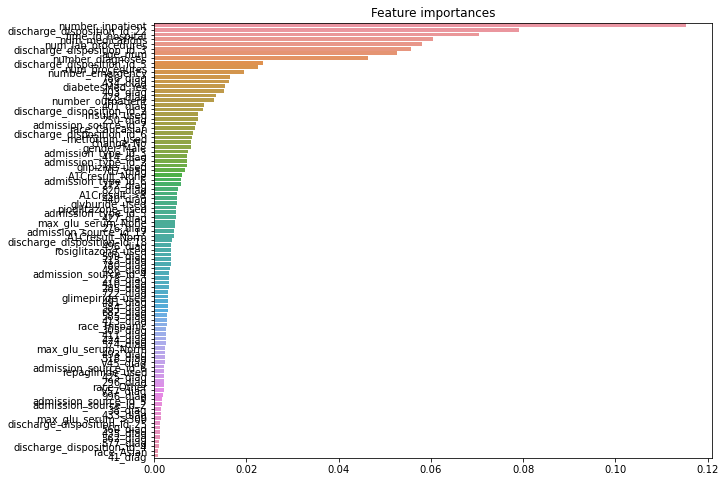

In [119]:
ftr_importances_values = grid.best_estimator_.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_sort = ftr_importances.sort_values(ascending=False)
plt.figure(figsize=(10,8))
plt.title('Feature importances')
sns.barplot(x=ftr_sort , y = ftr_sort.index)
plt.show()

In [120]:
import pandas as pd
feature_importances = pd.DataFrame(forest.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)


In [121]:
feature_importances

,importance
number_inpatient,0.158068
discharge_disposition_id_22,0.120506
discharge_disposition_id_3,0.096828
time_in_hospital,0.090391
age_num,0.061520
number_diagnoses,0.049580
num_medications,0.047855
discharge_disposition_id_5,0.031435
num_lab_procedures,0.029719
786_diag,0.026333


In [122]:
feature_importances.index

Index(['number_inpatient', 'discharge_disposition_id_22',
       'discharge_disposition_id_3', 'time_in_hospital', 'age_num',
       'number_diagnoses', 'num_medications', 'discharge_disposition_id_5',
       'num_lab_procedures', '786_diag', '434_diag', 'number_emergency',
       '403_diag', 'diabetesMed_Yes', '401_diag', '428_diag',
       'discharge_disposition_id_2', 'num_procedures', '707_diag', '440_diag',
       '272_diag', 'number_outpatient', '820_diag', 'insulin_used', '414_diag',
       'discharge_disposition_id_6', 'change_No', '250_diag', 'metformin_used',
       'glipizide_used', 'admission_type_id_6', 'race_Caucasian',
       'admission_type_id_5', '278_diag', 'admission_type_id_3', '722_diag',
       'admission_source_id_7', 'admission_type_id_2', 'max_glu_serum_None',
       '305_diag', 'race_Other', '276_diag', 'admission_source_id_17',
       '574_diag', '715_diag', 'gender_Male', '496_diag', '599_diag',
       'V45_diag', '413_diag', 'A1Cresult_>8', '486_diag', 'pio

### 3.3.4 RandomForest : class weight  = "balanced_subsample"

In [123]:
X = data.drop (['readmit_30d'], axis=1)
y = data['readmit_30d']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [124]:
from sklearn.ensemble import RandomForestClassifier
forest_sub = RandomForestClassifier(n_estimators= 200,
                                random_state=42,
                               class_weight = 'balanced_subsample',
                               max_depth = 5)

In [125]:
forest_sub.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                       n_estimators=200, random_state=42)

In [126]:
y_pred = forest_sub.predict(X_test)

### 3.3.4.1 GridSearch

In [127]:
params = {'n_estimators' : [120, 150, 200],
        'max_depth' : [8, 10, 12],
        'min_samples_split' : [8, 10, 12, 15],
        'min_samples_leaf' : [2, 4, 5, 7]}
grid = GridSearchCV(estimator=forest_sub, 
                    param_grid=params, 
                    n_jobs=-1, 
                    cv= 5, 
                    scoring='roc_auc')
grid_result = grid.fit(X_train, y_train)

In [128]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 200}
0.6462548791476612


In [129]:
roc_auc_score(y_test, y_pred)

0.6063176761515052

In [130]:
print(grid_result.score(X_train, y_train)) 
print(grid_result.score(X_test, y_test)) 

0.7284158928645037
0.646767260184476


In [131]:
y_pred_train = grid_result.predict(X_train)

In [132]:
y_pred_test = grid_result.predict(X_test)

In [133]:
print('auc_roc')
print(roc_auc_score(y_train, y_train_pred))
print(roc_auc_score(y_test, y_test_pred))

auc_roc
0.66310353610421
0.6037662365687575


### 3.3.4.2 Confusion Matrix

In [134]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],9333,3406
True[1],659,596


In [135]:
print('precision_score: %.3f' % precision_score(y_true=y_test, y_pred=y_test_pred))
print('recall_score: %.3f' % recall_score(y_true=y_test, y_pred=y_test_pred))
print('f1_score: %.3f' % f1_score(y_true=y_test, y_pred=y_test_pred))

precision_score: 0.149
recall_score: 0.475
f1_score: 0.227


### 3.3.4.3 precision recall curve

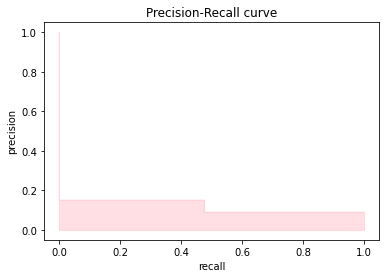

In [136]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)

plt.figure()
plt.step(recall, precision, color = "pink", alpha = 0.3, where = 'post')
plt.fill_between(recall, precision, step = 'post', alpha=0.5, color = "pink")
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall curve');

### 3.3.4.4 feature importance

In [137]:
grid.best_estimator_.feature_importances_

array([0.07325025, 0.05911684, 0.02224683, 0.05927064, 0.01303179,
       0.01881654, 0.11074497, 0.04640168, 0.05431881, 0.00238472,
       0.00264863, 0.00252698, 0.00165335, 0.00383534, 0.0026256 ,
       0.0048911 , 0.00318977, 0.00245481, 0.00250034, 0.0026704 ,
       0.00158605, 0.00092051, 0.0101526 , 0.00115637, 0.00497202,
       0.00089064, 0.00463437, 0.0061725 , 0.00327476, 0.00710461,
       0.01641092, 0.01592837, 0.00266498, 0.00362441, 0.00164096,
       0.00311851, 0.01473491, 0.00285583, 0.00290037, 0.00409007,
       0.00216322, 0.00196583, 0.00115559, 0.00267247, 0.00652274,
       0.00110379, 0.00195627, 0.00148191, 0.00090564, 0.01030525,
       0.00610927, 0.01642337, 0.00295542, 0.00233384, 0.00806262,
       0.00192179, 0.00267861, 0.00627616, 0.00525007, 0.00462107,
       0.00300918, 0.01071962, 0.00048265, 0.00849951, 0.00270091,
       0.00204065, 0.00832371, 0.0070392 , 0.00718104, 0.00461051,
       0.00574844, 0.00365066, 0.01077733, 0.08096387, 0.00117

In [140]:
feature_importances.index.to_list

<bound method IndexOpsMixin.tolist of Index(['number_inpatient', 'discharge_disposition_id_22',
       'discharge_disposition_id_3', 'time_in_hospital', 'age_num',
       'number_diagnoses', 'num_medications', 'discharge_disposition_id_5',
       'num_lab_procedures', '786_diag', '434_diag', 'number_emergency',
       '403_diag', 'diabetesMed_Yes', '401_diag', '428_diag',
       'discharge_disposition_id_2', 'num_procedures', '707_diag', '440_diag',
       '272_diag', 'number_outpatient', '820_diag', 'insulin_used', '414_diag',
       'discharge_disposition_id_6', 'change_No', '250_diag', 'metformin_used',
       'glipizide_used', 'admission_type_id_6', 'race_Caucasian',
       'admission_type_id_5', '278_diag', 'admission_type_id_3', '722_diag',
       'admission_source_id_7', 'admission_type_id_2', 'max_glu_serum_None',
       '305_diag', 'race_Other', '276_diag', 'admission_source_id_17',
       '574_diag', '715_diag', 'gender_Male', '496_diag', '599_diag',
       'V45_diag', '413_d

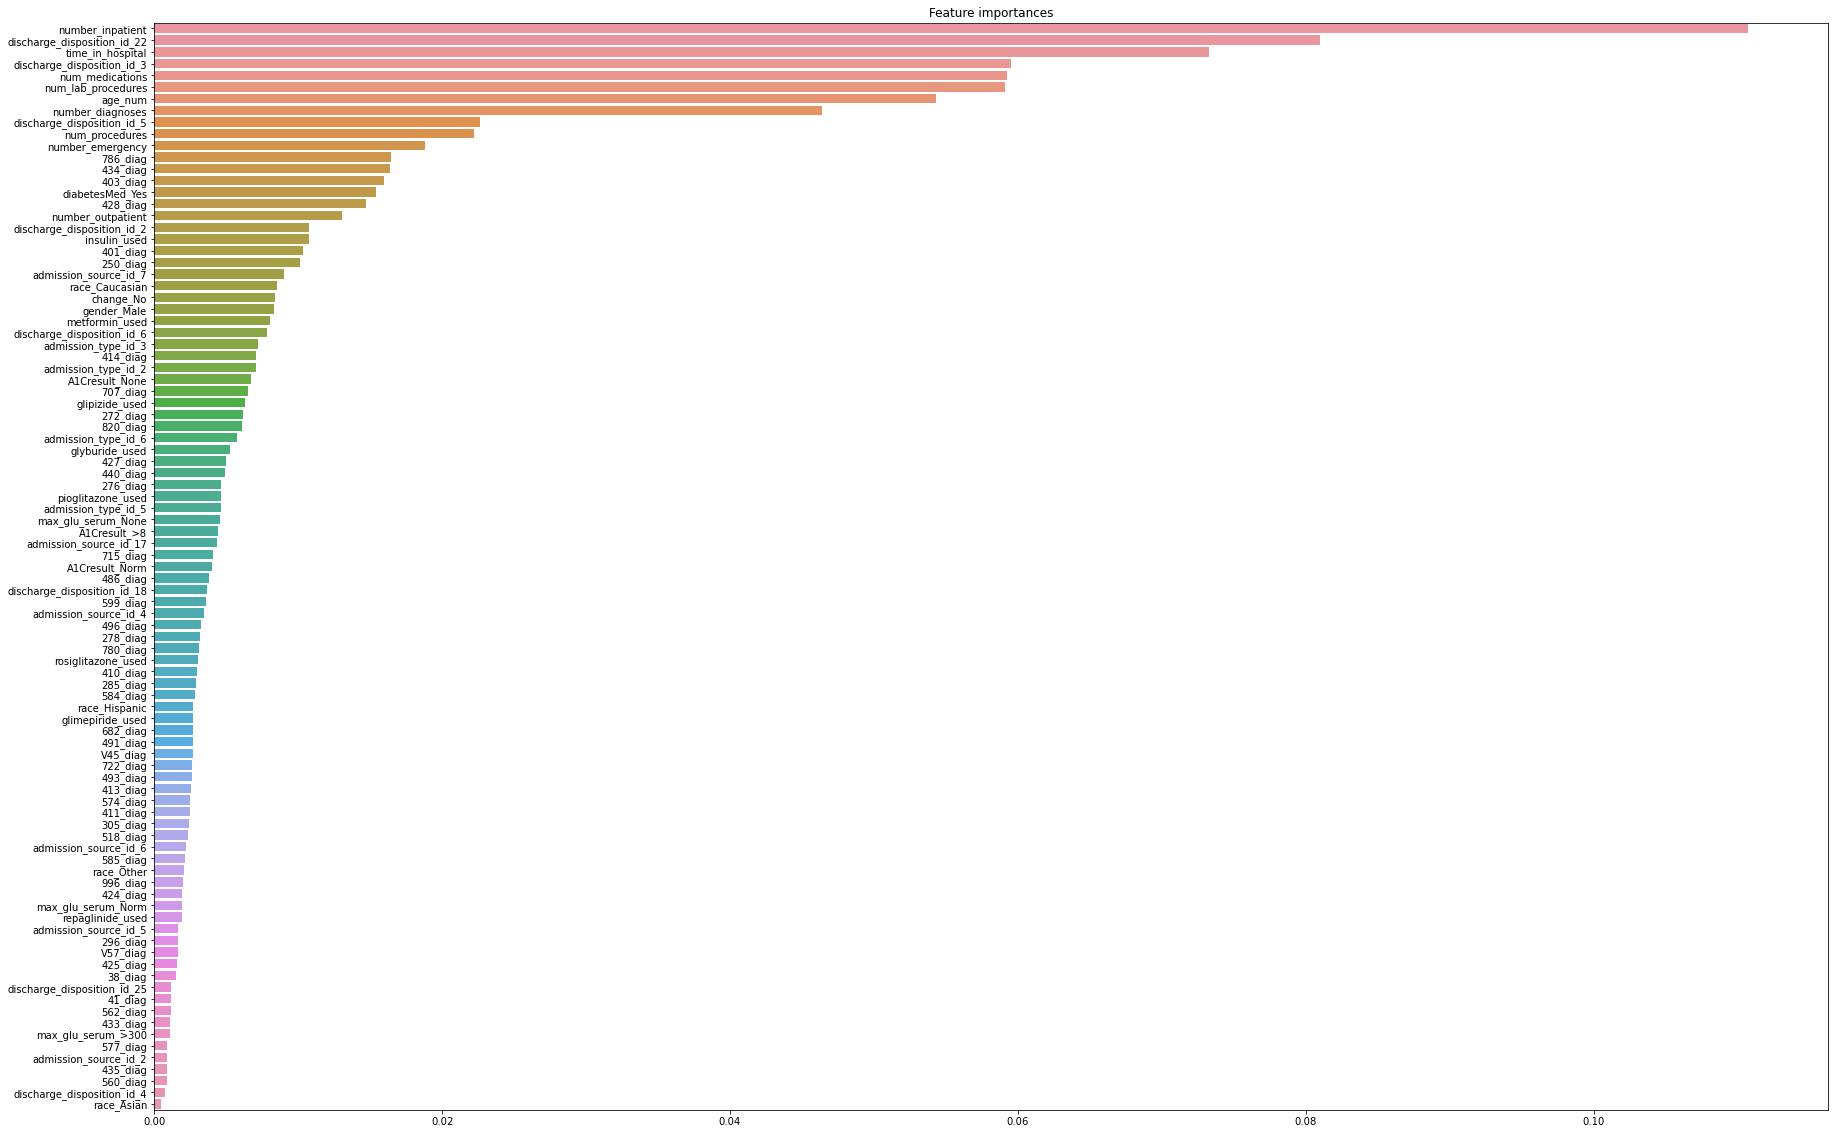

In [141]:
ftr_importances_values = grid.best_estimator_.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_sort = ftr_importances.sort_values(ascending=False)
plt.figure(figsize=(30,20))
plt.title('Feature importances')
sns.barplot(x=ftr_sort , y = ftr_sort.index)
plt.show()

In [142]:
import pandas as pd
feature_importances = pd.DataFrame(grid.best_estimator_.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)


In [143]:
feature_importances 

,importance
number_inpatient,0.110745
discharge_disposition_id_22,0.080964
time_in_hospital,0.073250
discharge_disposition_id_3,0.059514
num_medications,0.059271
num_lab_procedures,0.059117
age_num,0.054319
number_diagnoses,0.046402
discharge_disposition_id_5,0.022624
num_procedures,0.022247


In [144]:
top_43_features = ['number_inpatient', 'discharge_disposition_id_22', 'time_in_hospital',
       'num_lab_procedures', 'num_medications', 'age_num',
       'discharge_disposition_id_3', 'number_diagnoses',
       'discharge_disposition_id_5', 'num_procedures', 'number_emergency',
       '786_diag', '434_diag', '428_diag', 'number_outpatient',
       'diabetesMed_Yes', '403_diag', 'discharge_disposition_id_2', '401_diag',
       'insulin_used', 'admission_source_id_7', '250_diag', 'race_Caucasian',
       'gender_Male', 'change_No', '414_diag', 'admission_type_id_3',
       'glipizide_used', 'discharge_disposition_id_6', '820_diag',
       'metformin_used', '707_diag', 'admission_type_id_2', 'A1Cresult_None',
       'admission_type_id_6', '276_diag', '440_diag', 'admission_type_id_5',
       'glyburide_used', 'max_glu_serum_None', '427_diag', 'A1Cresult_>8',
       '599_diag']

### 3.5 Gradient Boosting

In [145]:
# Boosting model has same problem..High training accuracy, but low tests accuracy.
# It seems overfitting problem

### Train, Test split

In [146]:
top_43_features = ['number_inpatient', 'discharge_disposition_id_22', 'time_in_hospital',
       'discharge_disposition_id_3', 'age_num', 'num_medications',
       'number_diagnoses', 'discharge_disposition_id_5', 'num_lab_procedures',
       '434_diag', '786_diag', '403_diag', 'diabetesMed_Yes',
       'number_emergency', '401_diag', 'discharge_disposition_id_2',
       '428_diag', 'insulin_used', 'num_procedures', '440_diag', '707_diag',
       '272_diag', 'number_outpatient', '820_diag', 'admission_type_id_3',
       '278_diag', 'discharge_disposition_id_6', 'change_No', '414_diag',
       'admission_source_id_7', 'race_Other', 'admission_type_id_6',
       '250_diag', '305_diag', 'metformin_used', 'gender_Male', '722_diag',
       'race_Caucasian', 'glipizide_used', 'admission_type_id_5',
       'A1Cresult_None', '574_diag', 'pioglitazone_used']

In [147]:
X = data[top_43_features]
y= data['readmit_30d']

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

In [149]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier(n_estimators = 100, random_state=42,learning_rate=1.0 )
gbm.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1.0, random_state=42)

In [150]:
y_pred = gbm.predict(X_test)

In [151]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],12666,73
True[1],1220,35


In [152]:
params = {'n_estimators':[100, 150, 200], 'learning_rate' : [0.1, 0.5, 0.01]}
grid = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), 
                    param_grid=params, 
                    n_jobs=-1, 
                    cv= 5, 
                    scoring='roc_auc',
                    verbose = 1)
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  5.9min finished


In [153]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],12666,73
True[1],1220,35


In [154]:
print('precision_score: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('recall_score: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('f1_score: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))


precision_score: 0.324
recall_score: 0.028
f1_score: 0.051


In [155]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'learning_rate': 0.1, 'n_estimators': 200}
0.6471429169594496


In [156]:
print(grid_result.score(X_train, y_train)) 
print(grid_result.score(X_test, y_test)) 

0.6842954313029577
0.6496109603504501


In [157]:
roc_auc_score(y_test, y_pred)

0.5110790060575657

In [158]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

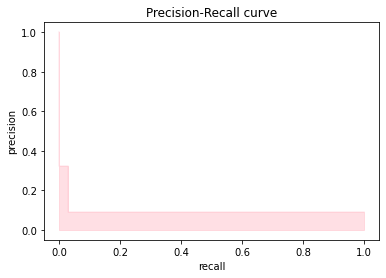

In [159]:
plt.figure()
plt.step(recall, precision, color = "pink", alpha = 0.3, where = 'post')
plt.fill_between(recall, precision, step = 'post', alpha=0.5, color = "pink")
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall curve');
params = {'n_estimators':[100,200]}

In [160]:
# !pip install imblearn

### SMOTE :  GradientBoostingClassifier()

In [161]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
# X_train_over,y_train_over = smote.fit_sample(X_train,y_train)

In [162]:
# import imblearn
## from imblearn.under_sampling import RandomUnderSampler
# undersample = RandomUnderSampler(sampling_strategy='majority')

In [163]:
from collections import Counter
from sklearn.datasets import make_classification
X = data[top_43_features]
y= data['readmit_30d']
# X, y = make_classification(weights=[0.9], flip_y=0)

In [164]:
X_train, X_test, y_train, y_test= train_test_split(X, y)

In [165]:
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_sample(X_train,y_train)

In [166]:
len(y_train)

52477

In [167]:
len(y_train_over)

95636

In [168]:
gbm = GradientBoostingClassifier()
gbm.fit(X_train_over,y_train_over)
y_pred = gbm.predict(X_test)

In [169]:
y_pred = gbm.predict(X_test)

In [170]:
params = {'n_estimators':[100,120, 150,180, 200], 'learning_rate' : [0.1, 0.5, 1.0, 1.5]}
grid = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), 
                    param_grid=params, 
                    n_jobs=-1, 
                    cv= 5, 
                    scoring='roc_auc',
                   verbose = 1)
grid_result = grid.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 23.1min finished


In [171]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'learning_rate': 0.5, 'n_estimators': 200}
0.918167883779055


In [172]:
y_predict = grid_result.best_estimator_.predict(X_test)

In [173]:
print(grid_result.score(X_train_over, y_train_over)) 
print(grid_result.score(X_test, y_test)) 

0.9311230947001792
0.5324850160108232


In [174]:
roc_auc_score(y_test, y_pred)

0.5055775673281878

###  XGBClassifier

In [175]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

[22:04:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [176]:
y_pred = gbm.predict(X_test)

In [177]:
weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)
grid = GridSearchCV(estimator=xgb, param_grid=param_grid, n_jobs=-1, cv=5, scoring='roc_auc')
grid_result = grid.fit(X_train, y_train)

[22:07:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [178]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],13246,2629
True[1],1332,286


In [179]:
print('precision_score: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('recall_score: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('f1_score: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

precision_score: 0.098
recall_score: 0.177
f1_score: 0.126


In [180]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'scale_pos_weight': 1}
0.6243174511678475


In [181]:
y_pred = gbm.predict(X_test)

In [182]:
print(grid_result.score(X_train, y_train)) 
print(grid_result.score(X_test, y_test)) 

0.8386976982222364
0.623148788725266


In [183]:
roc_auc_score(y_test, y_pred)

0.5055775673281878

In [184]:
y_predict = grid_result.best_estimator_.predict(X_test)

In [185]:
print(grid_result.score(X_train, y_train)) 
print(grid_result.score(X_test, y_test)) 

0.8386976982222364
0.623148788725266


### SMOTE : XGBClassifier

In [186]:
smote = SMOTE(random_state=0)
X = data[top_43_features]
y= data['readmit_30d']
X_train, X_test, y_train, y_test= train_test_split(X, y)
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_sample(X_train,y_train)

In [187]:
print(len(y_train))
print(len(y_train_over))

52477
95462


In [188]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_over, y_train_over)

[22:08:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [189]:
params = {'max_depth':range(3,10,2), 'min_child_weight':range(1,6,2)}
grid = GridSearchCV(estimator=xgb, param_grid=param_grid, n_jobs=-1, cv=5, scoring='roc_auc')
grid_result = grid.fit(X_train_over, y_train_over)

[22:14:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [190]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'scale_pos_weight': 1}
0.9257210469769612


In [191]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],13304,2658
True[1],1274,257


In [192]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'scale_pos_weight': 1}
0.9257210469769612


In [193]:
y_pred = gbm.predict(X_test)

In [194]:
roc_auc_score(y_test, y_pred)

0.5116329924982677

In [195]:
y_predict = grid_result.best_estimator_.predict(X_test)

In [196]:
print(grid_result.score(X_train, y_train)) 
print(grid_result.score(X_test, y_test)) 

0.7009963006176021
0.5487649226678221


In [ ]:
### SMOTE :  lightgbm.LGBMClassifier

In [197]:
import lightgbm

In [198]:
smote = SMOTE(random_state=0)
X = data[top_43_features]
y= data['readmit_30d']
X_train, X_test, y_train, y_test= train_test_split(X, y)
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_sample(X_train,y_train)

In [199]:
print(len(y_train))
print(len(y_train_over))

52477
95692


In [200]:
lgb = lightgbm.LGBMClassifier()
lgb.fit(X_train_over,y_train_over)
y_pred = gbm.predict(X_test)

In [201]:
y_pred = gbm.predict(X_test)

In [202]:
params = {'num_leaves' : [5,10,15], 'learning_rate' : [0.01, 0.1, 0.5], 'max_depth' : [5,10] ,'lambda_l1':[0.1,0.3,0.7]}
grid = GridSearchCV(estimator=lightgbm.LGBMClassifier(random_state=42, num_boost_round =3000, early_stoping_rounds = 1000, verbose_eval = 100), 
                    param_grid=params, 
                    n_jobs=-1, 
                    cv= 5, 
                    scoring='roc_auc')
grid_result = grid.fit(X_train_over, y_train_over)

In [203]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'lambda_l1': 0.3, 'learning_rate': 0.5, 'max_depth': -1, 'num_leaves': 15}
0.9584847786227071


In [204]:
y_pred = gbm.predict(X_test)

In [205]:
print(grid_result.score(X_train, y_train)) 
print(grid_result.score(X_test, y_test)) 

0.9998371024332882
0.5442144163956657


In [206]:
roc_auc_score(y_test, y_pred)

0.5060931418843359

In [207]:
y_predict = grid_result.best_estimator_.predict(X_test)

In [208]:
print(grid_result.score(X_train, y_train)) 
print(grid_result.score(X_test, y_test)) 

0.9998371024332882
0.5442144163956657
